In [19]:
from __future__ import division
import numpy as np


%matplotlib inline
plt.style.use('ggplot')

def init_lattice(n):

    '''Create a nxn lattice with random spin configuration'''
    
    lattice = np.random.choice([1, -1], size=(n, n))
    return lattice


def deltaE(S0, Sn, J, H):

    '''Energy difference for a spin flip'''
    
    return 2 * S0 * (H + J * Sn)


def ising(n=200, 
          nsteps=50000,
          H=0,
          J=1,
          T=1,
          count_spins = False,
          countij = [1,1],
          correlation=False,
          corr_ij=[0,0],
          corr_r=1):

    '''Ising Model Simulator. If count_spins = True, only flipping behavior of 1 site is studied.'''
    
    lattice = init_lattice(n)
    energy = 0
    energies = []
    spins = []
    spin = np.sum(lattice)
    icount, jcount = countij
    counted_spins = [lattice[icount, jcount]] 
    counted_intervals = []
    icorr, jcorr = corr_ij
    Sis = []
    SiSjs = []
    
    for step in xrange(nsteps):

        i = np.random.randint(n)
        j = np.random.randint(n)

        # Periodic Boundary Condition
        Sn = lattice[(i - 1) % n, j] + lattice[(i + 1) % n, j] + \
             lattice[i, (j - 1) % n] + lattice[i, (j + 1) % n]

        dE = deltaE(lattice[i, j], Sn, J, H)

        if dE < 0 or np.random.random() < np.exp(-dE/T):
            lattice[i, j] = -lattice[i, j]
            energy += dE
            energies.append(energy)
         # Note that the spin is collected at every step
            spin += 2*lattice[i, j]
        
        if count_spins:
            ispin = lattice[icount, jcount]
            if ispin != counted_spins[-1]:
                counted_spins.append(ispin)
                counted_interval = step - sum(counted_intervals)

                counted_intervals.append(counted_interval)
        if correlation:
            Sn_corr = lattice[(icorr - corr_r) % n, jcorr] + lattice[(icorr + corr_r) % n, jcorr] + \
                      lattice[icorr, (jcorr - corr_r) % n] + lattice[icorr, (jcorr + corr_r) % n]
            Si = lattice[icorr, jcorr]
            SiSj = Si * Sn_corr / 4.0
            Sis.append(Si)
            SiSjs.append(SiSj)
            
        spins.append(spin)


    if correlation:
        return Sis, SiSjs
    
    if count_spins:
        return counted_spins, counted_intervals
        
    return lattice, energies, spins
    

def ising1000(n=1000, nsteps=10000000000, H=0, J=1, T=1):

    '''Ising Model Simulator. Special case for very large lattices.
    To reduce some memory usage:
    spin is added to the array every 1000 steps.
    Energies are not returned.
    Still pretty inefficient!
    '''
    
    lattice = init_lattice(n)
    energy = 0

    spins = []
    spin = np.sum(lattice)
    for istep, step in enumerate(xrange(nsteps)):

        i = np.random.randint(n)
        j = np.random.randint(n)

        # Periodic Boundary Condition
        Sn = lattice[(i - 1) % n, j] + lattice[(i + 1) % n, j] + \
             lattice[i, (j - 1) % n] + lattice[i, (j + 1) % n]

        dE = deltaE(lattice[i, j], Sn, J, H)

        if dE < 0 or np.random.random() < np.exp(-dE/T):
            lattice[i, j] = -lattice[i, j]
            energy += dE
            spin += 2*lattice[i, j]
        if istep % 1000 == 0:
            spins.append(spin)
    return lattice, spins


def write_job_script(wd='./', n=10, s=1000, i=1, T=1., nprocs=1, pe='smp', name = 'batch', q = 'long'):
    '''
    This is a function that writes a script to submit MC jobs
    '''
    py_file = '/afs/crc.nd.edu/user/p/pmehta1/ising-monte-carlo/spins.py'
    script='''#!/bin/bash
#$ -N {0}
#$ -pe {1} {2}
#$ -q {3}
#$ -cwd
'''.format(name, pe, nprocs, q)
       
    if nprocs > 1:
        cmd = 'mpirun -np $NSLOTS python'
        script+='{6} {5} -n {0} -s {1} -i {2} -t {3} -w {4}'.format(n, s, i, T, wd, py_file, cmd)

    else:
        script+='python {5} -n {0} -s {1} -i {2} -t {3} -w {4}'.format(n, s, i, T, wd, py_file)

    with open('{0}/qscript'.format(wd), 'w') as f:
        f.write(script)

def run_job(wd):
    '''
    Submit job to the queue
    '''
    import os
    from subprocess import Popen, PIPE
    cwd = os.getcwd()
    os.chdir(wd)
    p = Popen(['qsub', 'qscript'], stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    
    if out == '' or err !='':
        raise Exception('something went wrong in qsub:\n\n{0}'.format(err))
    jobid = out.split()[2]
    f = open('jobid', 'w')
  
    f.write(jobid)
    f.close()
    os.chdir(cwd)
    return out.strip()    

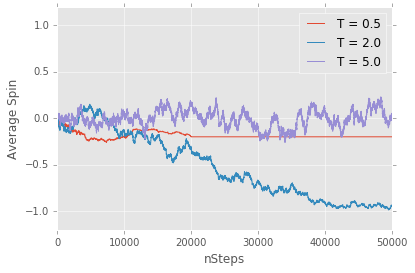

In [20]:
import matplotlib.pyplot as plt

temperatures = [0.5, 2.0, 5.0]

for T in temperatures:

    lattice, energies, spins = ising(n=20, nsteps = 50000, T=T)
    spins = np.array(spins) / 20. ** 2
    plt.plot(range(len(spins)), spins, label = 'T = {0}'.format(T))
plt.legend(loc = 'best')
plt.xlabel('nSteps')
plt.ylabel('Average Spin')
plt.ylim(-1.2, 1.2)
plt.savefig('/Users/namshik/Documents/py/average-spin.png')
plt.show()

In [23]:
lattice, energies, spins = ising(n=20, nsteps = 50000, T=2.0)

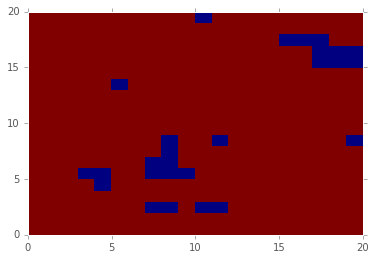

In [24]:
plt.pcolor(lattice)